In [1]:
# Importing the required modules

In [2]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.5 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [4]:
# Importing the dataset
df = pd.read_csv('Cleaned_Soil.csv')

In [5]:
# Obtaining data specific to Anantapur

In [6]:
df = df[df['District'] == 'Vizianagaram']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
3760,3763,18.75,83.31,Vizianagaram,Parvathipuram,Challam Valasa,Black,8.46,0.24,0.19,2.41,134.0,1340.0,300.0,22.99,0.26,0.25,13.79,1.39,6.48,0.439474,0.217271,0.870699,2.184862,-0.522087,Blackgram
3761,3764,18.76,83.31,Vizianagaram,Parvathipuram,Challam Valasa,Sandy,4.85,0.03,0.11,4.51,36.0,74.0,20.0,1.61,0.22,0.13,26.18,0.56,27.57,0.425949,0.208439,0.880121,1.780430,-0.470960,Sandy
3762,3765,18.75,83.31,Vizianagaram,Parvathipuram,Challam Valasa,Black,6.15,0.15,0.65,4.51,114.0,799.0,120.0,21.11,0.47,0.31,61.89,2.58,17.93,0.439474,0.217271,0.870699,2.184862,-0.522087,Paddy
3763,3766,18.76,83.30,Vizianagaram,Parvathipuram,Challam Valasa,Black,5.62,0.09,0.70,6.49,87.0,1066.0,135.0,13.03,0.41,0.38,110.16,3.16,16.98,0.396764,0.179577,0.799009,1.654367,-0.452710,Paddy
3764,3767,18.75,83.32,Vizianagaram,Parvathipuram,Challam Valasa,Black,6.86,0.30,0.89,25.21,433.0,1899.0,297.0,28.37,1.44,0.70,84.45,4.05,47.29,0.636605,0.443514,1.630158,2.905063,-0.592258,Blackgram


In [7]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'ARVI', 'EVI', 'NDVI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,GCI
count,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000,491.000000
mean,6.763747,0.291120,0.482342,11.691874,127.775967,1216.181263,300.458248,16.410978,0.880265,0.969328,46.068758,2.190916,33.159002,2.052234
std,1.175368,0.527502,0.187164,11.915978,94.141766,745.193780,204.656147,24.794001,0.796994,0.715113,42.332614,1.178898,24.745429,1.227629
min,4.770000,0.020000,0.030000,1.240000,12.000000,74.000000,10.000000,0.240000,0.120000,0.130000,2.180000,0.300000,3.150000,-0.479062
25%,5.635000,0.090000,0.360000,4.095000,70.500000,660.000000,134.500000,5.175000,0.470000,0.415000,12.450000,1.220000,15.880000,1.278396
50%,6.830000,0.170000,0.470000,6.670000,108.000000,1066.000000,260.000000,9.870000,0.680000,0.680000,30.520000,2.000000,27.570000,2.020867
75%,7.850000,0.300000,0.600000,14.810000,149.500000,1613.500000,429.000000,18.895000,0.970000,1.405000,70.660000,2.975000,40.355000,2.404040
max,9.500000,8.500000,1.310000,85.240000,809.000000,4246.000000,1308.000000,328.670000,7.320000,3.740000,236.900000,7.290000,163.030000,7.811594


In [8]:
# Analysis of SoilType

In [9]:
df.SoilType.unique()

array(['Black', 'Sandy', 'Red', 'Sandy Loam', 'Loam', 'White',
       'Sandyloam', 'Red Sandy', 'Sandy ', 'Black ', 'Sand',
       'Sandy Loam ', 'Cashewnut'], dtype=object)

In [10]:
df['SoilType'] = df['SoilType'].replace(['Black ', 'Black'], 'Black Soil')
df['SoilType'] = df['SoilType'].replace(['Red'], 'Red Soil')
df['SoilType'] = df['SoilType'].replace(['Sandy', 'Sandy ', 'Sand', 'Red Sandy'], 'Sandy Soil')
df['SoilType'] = df['SoilType'].replace(['Sandy Loam ', 'Sandyloam', 'Sandy Loam'], 'Sandy Loam Soil')
df['SoilType'] = df['SoilType'].replace('Loam', 'Loam Soil')
df = df[(df["SoilType"] != 'Cashewnut') & (df["SoilType"] != 'White')]
df.SoilType.unique()

array(['Black Soil', 'Sandy Soil', 'Red Soil', 'Sandy Loam Soil',
       'Loam Soil'], dtype=object)

In [11]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Black Soil': 107,
 'Loam Soil': 17,
 'Red Soil': 149,
 'Sandy Loam Soil': 145,
 'Sandy Soil': 71}

<BarContainer object of 5 artists>

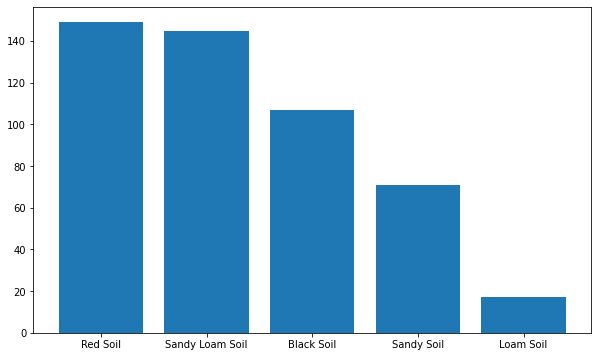

In [12]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [13]:
# Analysis of Crops grown 

In [14]:
df.Crop.unique()

array(['Blackgram', 'Sandy', 'Paddy', 'Sesumum', 'Sesamum', 'Maize',
       'Black Gram', 'Mango', 'Eucaliptus', 'Cashewnut', 'Ragi',
       'Mango(Intercrop Ragi,)', 'Cashew Nut', 'Mango(Intercrop Ragi)',
       'Mango(Inter Crop Ragi)', 'Red Gram',
       'Mango (Inter Crop Red Gram And Ragi)', 'Oil Palm', 'Mesta',
       'Cashewnut, Mango (Intercrop Maize And Seasamum)', 'Paady',
       'Chilli', 'Sugarcane', 'Banana', 'Coconut', 'Ground Nut', ' Maize',
       'Coconut (Intercop Maize)', 'Cashew Raina', 'Mc', 'Cotton'],
      dtype=object)

In [15]:
df['Crop'].value_counts()

Paddy                                              176
Maize                                              172
Sesamum                                             43
Coconut                                             26
Blackgram                                           13
Cashew Nut                                           8
Banana                                               7
Cashewnut                                            6
Mango                                                6
Ragi                                                 4
Mesta                                                3
Paady                                                3
Ground Nut                                           2
Mango(Inter Crop Ragi)                               2
Oil Palm                                             2
Cotton                                               1
Mango (Inter Crop Red Gram And Ragi)                 1
Sugarcane                                            1
Cashewnut,

Paddy        179
Maize        173
Sesamum       44
Coconut       27
CashewNut     15
BlackGram     14
Mango         12
Name: Crop, dtype: int64


<BarContainer object of 7 artists>

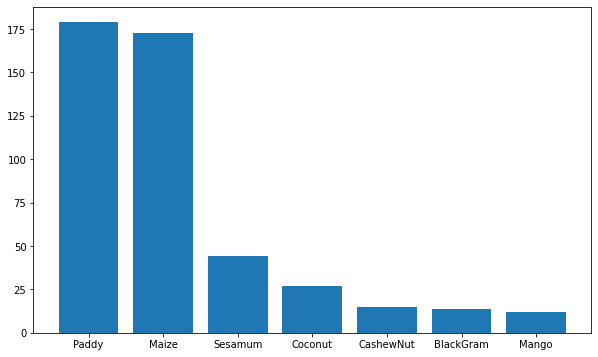

In [16]:
df['Crop'] = df['Crop'].replace(['Blackgram', 'Black Gram'], 'BlackGram')
df['Crop'] = df['Crop'].replace('Paady', 'Paddy')
df['Crop'] = df['Crop'].replace('Sesumum', 'Sesamum')
df['Crop'] = df['Crop'].replace(' Maize', 'Maize')
df['Crop'] = df['Crop'].replace(['Mango(Intercrop Ragi)', 'Mango(Intercrop Ragi,)', 'Mango(Inter Crop Ragi)', 'Mango (Inter Crop Red Gram And Ragi)', 'Cashewnut, Mango (Intercrop Maize And Seasamum)'], 'Mango')
df['Crop'] = df['Crop'].replace(['Cashewnut', 'Cashew Nut', 'Cashew Raina'], 'CashewNut')
df['Crop'] = df['Crop'].replace('Coconut (Intercop Maize)', 'Coconut')
df = df[(df['Crop'] != 'Sandy') & (df['Crop'] != 'Eucaliptus') & (df['Crop'] != 'Mc') & (df['Crop'] != 'Mesta') & (df['Crop'] != 'Chilli') & (df['Crop'] != 'Red Gram') & (df['Crop'] != 'Oil Palm') & (df['Crop'] != 'Ragi') & (df['Crop'] != 'Sugarcane') & (df['Crop'] != 'Cotton') & (df['Crop'] != 'Ground Nut')]
df = df[df['Crop'] != 'Banana']

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [17]:
# Getting rid of features that have a high correlation among one another

In [18]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,GCI
pH,1.000000,0.281542,0.035015,0.398014,0.317697,0.545172,0.674187,0.252758,0.186213,0.669005,-0.669751,-0.246604,-0.343555,-0.138463
EC,0.281542,1.000000,0.235520,0.346411,0.304910,0.243800,0.491103,0.846380,0.314124,0.349722,-0.146395,0.048183,-0.054909,-0.148725
OC,0.035015,0.235520,1.000000,0.193455,0.228135,0.422226,0.363388,0.354167,0.273680,0.292924,0.337670,0.696471,0.062055,0.010683
P,0.398014,0.346411,0.193455,1.000000,0.463098,0.172051,0.389330,0.380022,0.612654,0.477513,-0.123186,-0.011556,-0.109731,-0.068810
K,0.317697,0.304910,0.228135,0.463098,1.000000,0.266066,0.345684,0.280814,0.352003,0.335616,-0.248655,-0.081370,0.065889,-0.003850
Ca,0.545172,0.243800,0.422226,0.172051,0.266066,1.000000,0.779671,0.307892,0.024606,0.458529,-0.174735,0.284958,-0.212633,-0.099898
Mg,0.674187,0.491103,0.363388,0.389330,0.345684,0.779671,1.000000,0.478890,0.139498,0.739764,-0.319765,0.154586,-0.228722,-0.159800
S,0.252758,0.846380,0.354167,0.380022,0.280814,0.307892,0.478890,1.000000,0.301916,0.400227,-0.029385,0.196379,-0.060452,-0.137417
Zn,0.186213,0.314124,0.273680,0.612654,0.352003,0.024606,0.139498,0.301916,1.000000,0.173359,-0.006438,0.089369,0.105286,0.026608
B,0.669005,0.349722,0.292924,0.477513,0.335616,0.458529,0.739764,0.400227,0.173359,1.000000,-0.330251,0.070365,-0.320651,-0.164281


In [19]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)

Columns to be dropped :  ['Ca', 'Mg', 'S', 'Zn', 'B', 'Cu']


In [20]:
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'OC', 'P', 'K', 'Fe', 'Mn', 'GCI', 'Crop']


In [21]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [22]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

        pH    EC    OC     P  ...  Loam Soil  Red Soil  Sandy Loam Soil  Sandy Soil
3760  8.46  0.24  0.19  2.41  ...          0         0                0           0

[1 rows x 13 columns]
3760    BlackGram
Name: Crop, dtype: object


In [23]:
# Standardizing the independent variables using Feature Scaling
sc1 = StandardScaler()
X[:, 0:8] = sc1.fit_transform(X[:, 0:8])

In [24]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# SMOTE: Synthetic Minority Over-sampling Technique

In [25]:
# Separating the dependent and independent variables
df = df.drop(['SoilType'], axis=1)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [26]:
# Standardizing the independent variables using Feature Scaling
sc2 = StandardScaler()
X[:, :] = sc2.fit_transform(X[:, :])

In [27]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [28]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [29]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [30]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7770700636942676


In [31]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 79.76 %
Standard Deviation: 3.72 %


# Decision Tree Classifier

In [32]:
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [33]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [34]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7579617834394905


In [35]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 78.59 %
Standard Deviation: 2.95 %


# Random Forest Classifier

In [36]:
clf3_3 = RandomForestClassifier(random_state=0)
clf3_3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [37]:
y_test_pred = clf3_3.predict(X_test)
y_train_pred = clf3_3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [38]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8471337579617835


In [39]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3_3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 86.90 %
Standard Deviation: 3.27 %


# XGBoost

In [40]:
clf4 = HistGradientBoostingClassifier(random_state=0)
clf4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [41]:
y_test_pred = clf4.predict(X_test)
y_train_pred = clf4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [42]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8662420382165605


In [43]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4, X = X_train, y = y_train, cv = 10)

In [44]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 87.22 %
Standard Deviation: 3.39 %


In [45]:
pickle.dump(clf4, open('Vizianagaram_model.pkl', 'wb'))
pickle.dump(sc2, open('Vizianagaram_scaler.pkl', 'wb'))

# Multi-layer Perceptron Classifier

In [46]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [47]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [48]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.8594249201277955
Testing Accuracy:  0.7898089171974523


In [49]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 80.40 %
Standard Deviation: 4.99 %


# Catboost

In [50]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 1.2484362	total: 48ms	remaining: 4.75s
1:	learn: 1.1114448	total: 50.7ms	remaining: 2.48s
2:	learn: 0.9920804	total: 52.5ms	remaining: 1.7s
3:	learn: 0.9345993	total: 54.3ms	remaining: 1.3s
4:	learn: 0.8906061	total: 56.2ms	remaining: 1.07s
5:	learn: 0.8434092	total: 57.9ms	remaining: 907ms
6:	learn: 0.8206615	total: 59.6ms	remaining: 791ms
7:	learn: 0.7767758	total: 61.6ms	remaining: 709ms
8:	learn: 0.7453969	total: 63.3ms	remaining: 641ms
9:	learn: 0.6801870	total: 65.1ms	remaining: 586ms
10:	learn: 0.6501160	total: 66.8ms	remaining: 540ms
11:	learn: 0.6301526	total: 68.4ms	remaining: 502ms
12:	learn: 0.6211983	total: 70.1ms	remaining: 469ms
13:	learn: 0.6063440	total: 71.9ms	remaining: 441ms
14:	learn: 0.5948502	total: 73.9ms	remaining: 419ms
15:	learn: 0.5737022	total: 75.8ms	remaining: 398ms
16:	learn: 0.5672516	total: 77.5ms	remaining: 378ms
17:	learn: 0.5601269	total: 79.1ms	remaining: 360ms
18:	learn: 0.5573916	total: 80.7ms	remaining: 344ms
19:	learn: 0.5469397	total

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9853433065
bestIteration = 99

Training on fold [1/5]

bestTest = 1.038388953
bestIteration = 99

Training on fold [2/5]

bestTest = 1.030939205
bestIteration = 99

Training on fold [3/5]

bestTest = 0.9896513221
bestIteration = 99

Training on fold [4/5]

bestTest = 0.9881927181
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 1.5964771	total: 521ms	remaining: 2m 53s
3:	learn: 1.5060681	total: 702ms	remaining: 2m 54s
4:	learn: 1.4189750	total: 876ms	remaining: 2m 54s
5:	learn: 1.3429860	total: 1.05s	remaining: 2m 53s
6:	learn: 1.2781499	total: 1.22s	remaining: 2m 53s
7:	learn: 1.2233355	total: 1.39s	remaining: 2m 52s
8:	learn: 1.1671306	total: 1.56s	remaining: 2m 52s
9:	learn: 1.1240459	total: 1.76s	remaining: 2m 54s
10:	learn: 1.0721787	total: 1.94s	remaining: 2m 54s
11:	learn: 1.0299466	total: 2.1s	remaining: 2m 53s
12:	learn: 0.9912532	total: 2.29s	remaining: 2m 53s
13:	learn: 0.9574213	total: 2.46s	remaining: 2m 53s
14:	learn: 0.9223924	total: 2.64s	remaining: 2m 53s
15:	learn: 0.8907119	total: 2.82s	remaining: 2m 53s
16:	learn: 0.8615855	total: 2.99s	remaining: 2m 53s
17:	learn: 0.8333594	total: 3.16s	remaining: 2m 52s
18:	learn: 0.8074394	total: 3.34s	remaining: 2m 52s
19:	learn: 0.7836552	total: 3.52s	remaining: 2m 52s
20:	learn: 0.7607472	t